In [1]:
import pandas as pd

small = pd.read_csv('./datasets/sba/small.csv')
big = pd.read_csv('./datasets/sba/big.csv')

/var/folders/jc/pxhqyp6x0ps4r4ws70zc84m00000gn/T/ipykernel_52030/4078205992.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  big = pd.read_csv('./datasets/sba/big.csv')


In [2]:
print(big.shape)
print(big.isnull().sum())

(899164, 27)
LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64


In [3]:
big = big[big["MIS_Status"].notna()]
big = big[big["NewExist"].notna()]
big = big[big["NAICS"] != 0]
big = big[big["NewExist"] != 0]

In [4]:
def naics_to_anzsic(naics):

    mapper = {
        "11": "A", "21": "B", "31": "C", "32": "C",
        "33": "C", "22": "D", "23": "E", "42": "F",
        "44": "G", "45": "G", "48": "I", "49": "I",
        "51": "J", "52": "K", "53": "L", "54": "M",
        "55": "M", "56": "N", "61": "P", "62": "Q",
        "71": "R", "72": "H", "81": "S", "92": "O"
    }

    anzsic = mapper[str(naics)[:2]]
    return anzsic

def urban_rural(ordinal):

    return {
        0: "UNDEFINED",
        1: "URBAN",
        2: "RURAL"
    }[ordinal]

def new_existing(ordinal):

    return {
        1: "EXISTING",
        2: "NEW"
    }[ordinal]

In [5]:
big["ANZSIC"] = big["NAICS"].apply(naics_to_anzsic)
big["UrbanRural"] = pd.Categorical(big["UrbanRural"].apply(urban_rural))
big["NewExist"] = pd.Categorical(big["NewExist"].apply(new_existing))
big["ANZSIC"] = pd.Categorical(big["ANZSIC"])
big["MIS_Status"] = pd.Categorical(big["MIS_Status"])

In [6]:
X = big[["Term", "NoEmp", "NewExist", "UrbanRural", "ANZSIC"]] 
Y = big["MIS_Status"]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

In [8]:
X_train

,Term,NoEmp,NewExist,UrbanRural,ANZSIC
272037,65,1,NEW,URBAN,P
128865,75,2,EXISTING,URBAN,G
445404,180,1,EXISTING,RURAL,C
184636,84,1,EXISTING,RURAL,E
734745,10,3,EXISTING,URBAN,G
...,...,...,...,...,...
70647,84,142,EXISTING,UNDEFINED,E
224036,48,2,EXISTING,URBAN,S
618464,82,52,EXISTING,UNDEFINED,C
158292,60,0,NEW,URBAN,I


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ["NewExist", "UrbanRural", "ANZSIC"]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=7, random_state=0))
])

clf.fit(X_train, y_train)


/Users/urav/code/foundershack/models/venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['NewExist', 'UrbanRural',
                                                   'ANZSIC'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=7, random_state=0))])

In [10]:
y_pred = clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.3f}%")


Accuracy: 86.263%


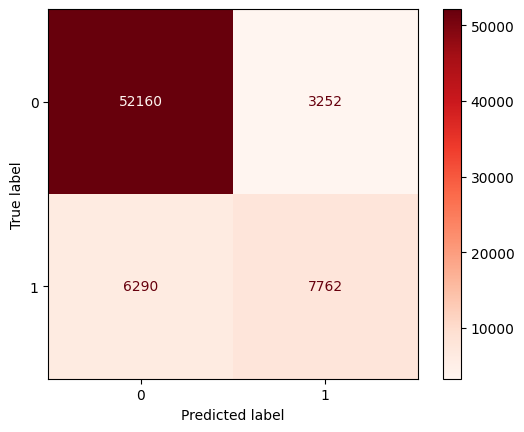

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_defaults = y_test != "P I F"
predicted_defaults = y_pred != "P I F"

cm = confusion_matrix(true_defaults, predicted_defaults)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Reds')